# 基于PYNQ-Z2的硬件加速实时音频分析系统
1. 加速器初始化 (System Initialization)
2. 算力性能基准测试 (Performance Benchmark)
3. 边缘计算实时链路 (Edge Computing Loop)

## FPGA 硬件加速演示：FFT 与 FIR 滤波

本栏代码旨在演示基于 PYNQ-Z2 开发板的 FPGA 硬件加速性能。
我们将对比 **纯软件实现 (CPU)** 与 **硬件加速实现 (FPGA)** 在以下两个任务上的效率：
1. **FFT (快速傅里叶变换)**
2. **FIR 滤波 + FFT 完整链路**

### 1. 系统初始化与信号生成
在此步骤中，我们加载自定义的Overlay。该比特流中集成了我们使用 **Vitis HLS** 设计的高性能 IP 核：
* **HLS_FFT**: 采用 AXI-Stream 接口的 4096点 流水线 FFT。
* **HLS_FIR**: 用于信号均衡与降噪的 FIR 滤波器。

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay, allocate, PL
from scipy import signal
import signal_generator as sg

# --- Configuration ---
FFT_LEN = 4096
FS = 4096

# --- Load Overlay ---
BITSTREAM_PATH = "design_1_wrapper.bit" # Fallback

print(f"Loading Overlay: {BITSTREAM_PATH}")
overlay = Overlay(BITSTREAM_PATH)
print("Loading Sussessfully")

Loading Overlay: design_1_wrapper.bit


Loading Sussessfully


In [2]:
# Initialize DMAs
dma_data = overlay.axi_dma_0 # Data Path
dma_coef = overlay.axi_dma_1 # Coefficient Reload Path

print("DMAs initialized.")

DMAs initialized.


In [3]:
# --- Helper Functions ---

def reload_fir_coefficients(coeffs):
    """Reloads FIR filter coefficients using DMA."""
    coeffs_int16 = np.array(coeffs, dtype=np.int16)
    buffer_size = len(coeffs_int16)
    coef_buffer = allocate(shape=(buffer_size,), dtype=np.int32)
    np.copyto(coef_buffer, coeffs_int16)
    dma_coef.sendchannel.transfer(coef_buffer)
    dma_coef.sendchannel.wait()
    del coef_buffer

def run_hardware_chain(signal_data):
    """Executes Hardware FIR -> FFT chain."""
    in_buffer = allocate(shape=(FFT_LEN,), dtype=np.int32)
    # Ensure signal is within int16 range
    sig_int16 = np.int16(signal_data)
    np.copyto(in_buffer, sig_int16)
    
    out_buffer = allocate(shape=(FFT_LEN,), dtype=np.float32)
    
    start_time = time.perf_counter()
    dma_data.recvchannel.transfer(out_buffer)
    dma_data.sendchannel.transfer(in_buffer)
    dma_data.sendchannel.wait()
    dma_data.recvchannel.wait()
    end_time = time.perf_counter()
    
    result = np.copy(out_buffer)
    del in_buffer
    del out_buffer
    
    exec_time_ms = (end_time - start_time) * 1000
    return result, exec_time_ms

def software_fft(signal_data):
    """Executes Software FFT."""
    start_time = time.perf_counter()
    result = np.abs(np.fft.fft(signal_data))
    end_time = time.perf_counter()
    exec_time_ms = (end_time - start_time) * 1000
    return result, exec_time_ms

def get_fir_coeffs(filter_type, cutoff_hz, num_taps=21, gain=100):
    """Generates FIR coefficients."""
    nyq = 0.5 * FS
    norm_cutoff = cutoff_hz / nyq
    norm_cutoff = np.clip(norm_cutoff, 0.01, 0.99)
    
    if filter_type == "Pass-Through":
        coeffs = np.zeros(num_taps)
        coeffs[10] = 0.2
    elif filter_type == "Low-Pass":
        coeffs = signal.firwin(num_taps, norm_cutoff)
    elif filter_type == "High-Pass":
        coeffs = signal.firwin(num_taps, norm_cutoff, pass_zero=False)
    elif filter_type == "Band-Pass":
        width = 0.1
        low = max(0.01, norm_cutoff - width)
        high = min(0.99, norm_cutoff + width)
        coeffs = signal.firwin(num_taps, [low, high], pass_zero=False)
    else:
        coeffs = np.zeros(num_taps)
        coeffs[num_taps // 2] = 1.0

    return np.int16(coeffs * gain)

# Global storage for benchmark results
benchmark_results = {}

In [4]:
# --- Generate 6 Simulated Signals ---
t = np.arange(FFT_LEN) / FS
signals = {}

# 1. White Noise
signals["Noise"] = sg.generate_white_noise(FFT_LEN)

# 2. Sine Wave (50Hz)
signals["Sine_50Hz"] = sg.generate_sine_wave(t, freq=50, amplitude=500)

# 3. Multi-Sine (50Hz + 200Hz + 1000Hz)
signals["Multi_Sine"] = sg.generate_multi_sine_wave(t, freqs=[50, 200, 1000], amplitudes=[0.5, 0.3, 0.2], base_amplitude=500)

# 4. Square Wave (50Hz)
signals["Square_50Hz"] = sg.generate_square_wave(t, freq=50, amplitude=500)

# 5. Chirp Signal (10Hz - 1000Hz)
signals["Chirp"] = sg.generate_chirp_signal(t, start_freq=10, end_freq=1000, amplitude=500)

# 6. AM Signal (Carrier 500Hz, Signal 20Hz)
signals["AM_Signal"] = sg.generate_am_signal(t, carrier_freq=500, signal_freq=20, amplitude=500)

print("Generated Signals:", list(signals.keys()))

# Set Pass-Through filter for pure FFT comparison initially
coeffs_pass = get_fir_coeffs("Pass-Through", 0)
reload_fir_coefficients(coeffs_pass)
print("FIR Filter set to Pass-Through mode.")

Generated Signals: ['Noise', 'Sine_50Hz', 'Multi_Sine', 'Square_50Hz', 'Chirp', 'AM_Signal']
FIR Filter set to Pass-Through mode.


### 2. 硬件/软件FFT性能对比测试
为了量化 FPGA 的加速效果，我们搭建了同构对比链路：
* **Hardware Chain**:  DMA搬运 -> PL端流水线处理 (FIR + FFT) -> 结果回传
* **Software Chain**:  ARM CPU -> NumPy/SciPy 纯软件计算

**测试目标**：
验证在 **4096点 高精度FFT** 负载下，硬件加速相比纯软件方案的**加速比 (Speedup Ratio)** 与 **低延迟 (Latency)** 优势。

初始状态下，我们将 FIR 滤波器配置为 **直通模式 (Pass-Through)**，以便首先专注于 FFT 的性能对比。

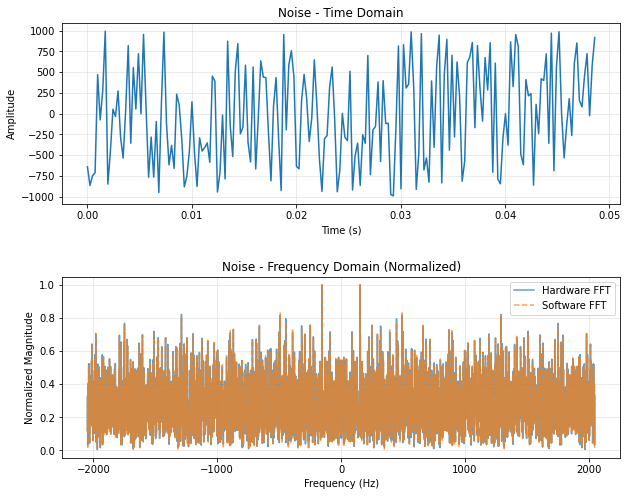

--- Noise Benchmark ---
Hardware Execution Time: 1.4011 ms
Software Execution Time: 4.1806 ms
Hardware Acceleration Speedup: 2.98x


In [5]:
signal_name = "Noise"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

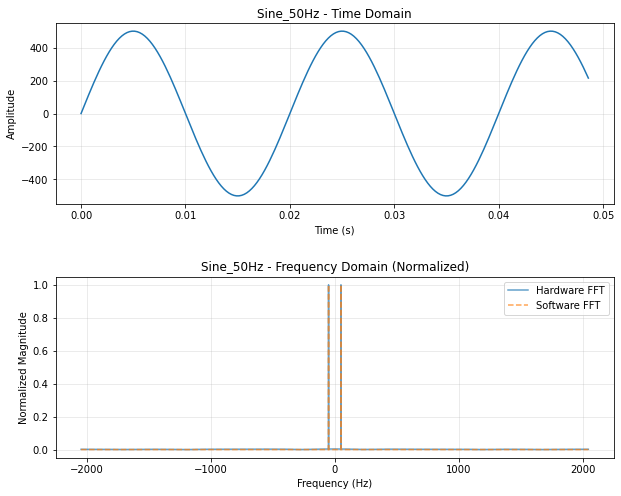

--- Sine_50Hz Benchmark ---
Hardware Execution Time: 1.4983 ms
Software Execution Time: 3.1369 ms
Hardware Acceleration Speedup: 2.09x


In [6]:
signal_name = "Sine_50Hz"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

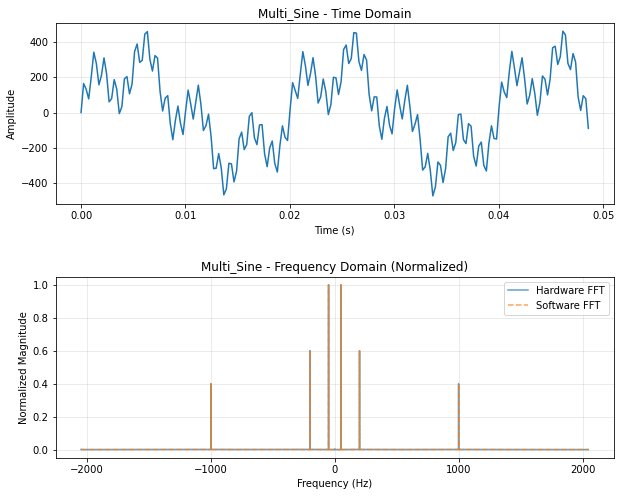

--- Multi_Sine Benchmark ---
Hardware Execution Time: 1.4401 ms
Software Execution Time: 2.9265 ms
Hardware Acceleration Speedup: 2.03x


In [7]:
signal_name = "Multi_Sine"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

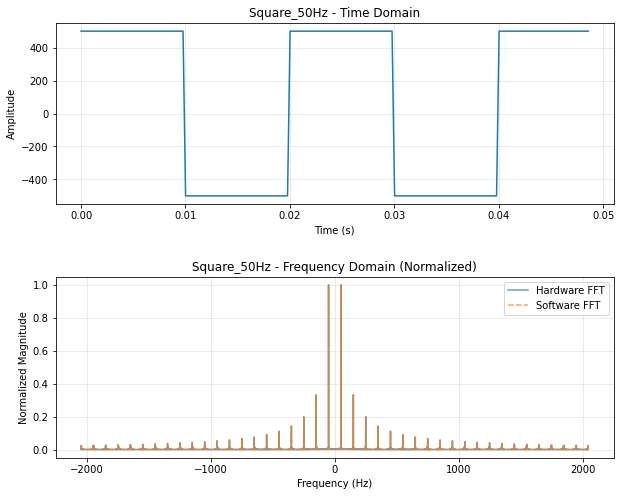

--- Square_50Hz Benchmark ---
Hardware Execution Time: 1.4980 ms
Software Execution Time: 2.1435 ms
Hardware Acceleration Speedup: 1.43x


In [8]:
signal_name = "Square_50Hz"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

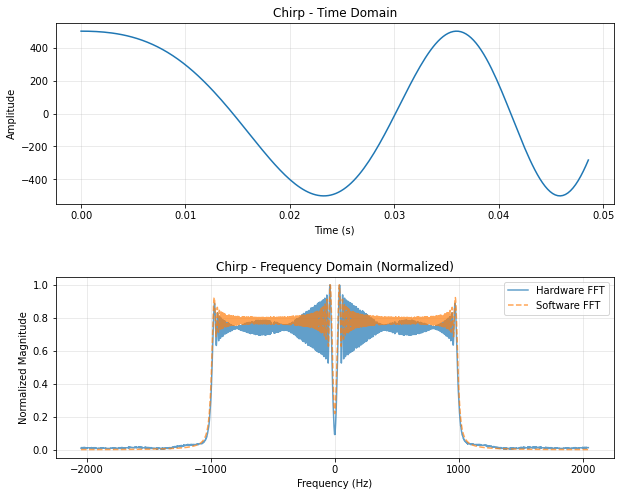

--- Chirp Benchmark ---
Hardware Execution Time: 1.4085 ms
Software Execution Time: 2.8050 ms
Hardware Acceleration Speedup: 1.99x


In [9]:
signal_name = "Chirp"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

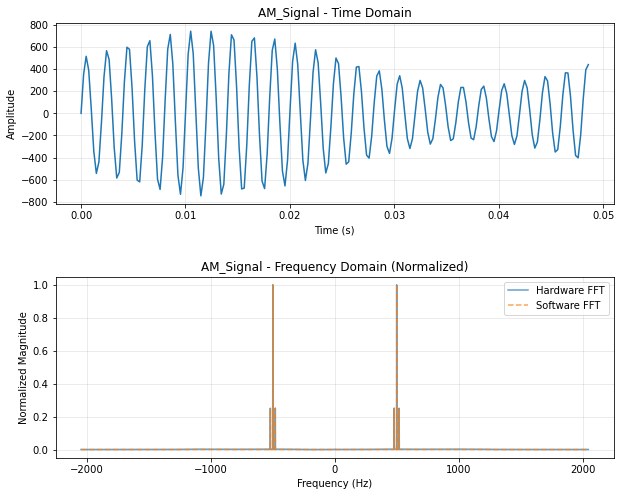

--- AM_Signal Benchmark ---
Hardware Execution Time: 1.4352 ms
Software Execution Time: 2.8436 ms
Hardware Acceleration Speedup: 1.98x


In [10]:
signal_name = "AM_Signal"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

### 3. FFT 性能测试总结
汇总上述各信号的测试结果，通过柱状图直观展示硬件加速在 FFT 计算上的速度优势。

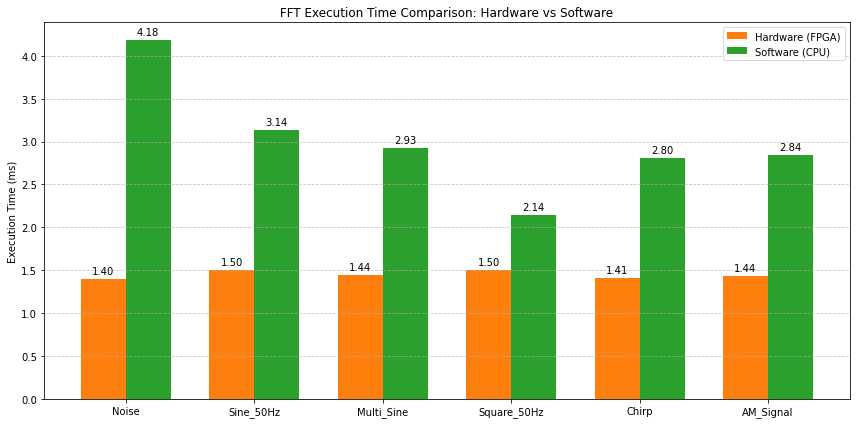

In [11]:
# --- Performance Summary ---
names = list(benchmark_results.keys())
hw_times = [benchmark_results[n][0] for n in names]
sw_times = [benchmark_results[n][1] for n in names]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, hw_times, width, label='Hardware (FPGA)', color='#ff7f0e')
rects2 = ax.bar(x + width/2, sw_times, width, label='Software (CPU)', color='#2ca02c')

ax.set_ylabel('Execution Time (ms)')
ax.set_title('FFT Execution Time Comparison: Hardware vs Software')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()

### 4. 完整链路对比：FIR 滤波 + FFT
为了更全面地评估硬件加速效果，我们引入 FIR 滤波环节。
此处定义一个软件函数，使用 `scipy.signal.lfilter` 模拟 FIR 滤波，再进行 FFT，从而构建一个与硬件链路对等的软件处理流程。

In [12]:
def software_fir_fft(signal_data, coeffs_int16, gain=100):
    """
    Executes Software FIR -> FFT chain for comparison.
    Simulates the hardware chain in software using scipy.signal.lfilter.
    """
    start_time = time.perf_counter()
    
    # Convert int16 coeffs back to float for Scipy
    coeffs_float = coeffs_int16.astype(np.float32) / gain
    
    # Software FIR Filtering 
    # b = coeffs, a = 1.0 (FIR)
    filtered_signal = signal.lfilter(coeffs_float, 1.0, signal_data)
    
    # Software FFT
    result = np.abs(np.fft.fft(filtered_signal))
    
    end_time = time.perf_counter()
    exec_time_ms = (end_time - start_time) * 1000
    return result, exec_time_ms

print("Software Full Chain (FIR + FFT) function defined.")

Software Full Chain (FIR + FFT) function defined.


### 5. 最终实测：硬件 vs 软件 (滤波+FFT)
使用 **多频正弦信号 (Multi-Sine)** 和 **低通滤波器 (Low-Pass)** 进行最终测试。
*   **频谱图**：对比原始信号、硬件处理结果和软件处理结果，验证滤波效果。
*   **耗时对比**：展示在包含滤波计算的情况下，硬件加速带来的性能提升。

--- Efficiency Comparison (Signal: Multi_Sine, Filter: Low-Pass) ---
Hardware (FIR + FFT): 1.4839 ms
Software (FIR + FFT): 5.5469 ms
Speedup Factor: 3.74x


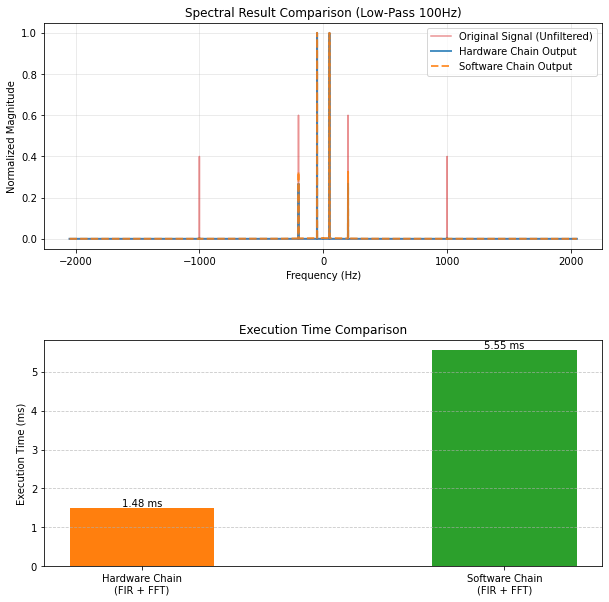

In [13]:
# --- Benchmark: Hardware Chain vs Software Full Chain ---

# Configuration
test_signal = signals["Multi_Sine"]
# Generate Low-Pass coefficients (using default 21 taps)
coeffs_lp = get_fir_coeffs("Low-Pass", cutoff_hz=100, num_taps=21, gain=100)

# 1. Run Hardware Chain (Reload Coeffs + Process)
reload_fir_coefficients(coeffs_lp)
# Warmup
run_hardware_chain(test_signal)
# Measure
hw_res, hw_time = run_hardware_chain(test_signal)

# 2. Run Software Chain
sw_res, sw_time = software_fir_fft(test_signal, coeffs_lp, gain=100)

# 3. Get Original Signal Spectrum for comparison
orig_fft = np.abs(np.fft.fft(test_signal))

# Normalize for plotting
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)
orig_norm = orig_fft / np.max(orig_fft)

# --- Visualization ---
print(f"--- Efficiency Comparison (Signal: Multi_Sine, Filter: Low-Pass) ---")
print(f"Hardware (FIR + FFT): {hw_time:.4f} ms")
print(f"Software (FIR + FFT): {sw_time:.4f} ms")
print(f"Speedup Factor: {sw_time / hw_time:.2f}x")

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

# Plot 1: Frequency Domain Comparison
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
# Plot Original Signal
axs[0].plot(np.fft.fftshift(freqs), np.fft.fftshift(orig_norm), label="Original Signal (Unfiltered)", color='#d62728', alpha=0.5, linestyle='-', linewidth=1.5)
# Plot Processed Signals
axs[0].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware Chain Output", alpha=0.8, linewidth=2)
axs[0].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software Chain Output", alpha=0.8, linestyle="--", linewidth=2)

axs[0].set_title("Spectral Result Comparison (Low-Pass 100Hz)")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Normalized Magnitude")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Execution Time Comparison
methods = ['Hardware Chain\n(FIR + FFT)', 'Software Chain\n(FIR + FFT)']
times = [hw_time, sw_time]
colors = ['#ff7f0e', '#2ca02c']

bars = axs[1].bar(methods, times, color=colors, width=0.4)
axs[1].set_ylabel('Execution Time (ms)')
axs[1].set_title('Execution Time Comparison')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} ms',
             ha='center', va='bottom')

plt.show()

## 3. 边缘计算实时链路 (Edge Computing Loop)
**概要**：
启动板载实时处理任务。该模块体现了系统的**高集成度**与**实时性**：
1.  **音频采集**：多条链路（麦克风/电脑实时监听/内置音频文件）可供选择
2.  **PL端加速**：数据流经 FPGA 完成硬件 FFT 变换（4096点高分辨率）
3.  **网络分发**：利用 **千兆以太网 (UDP)** 将处理后的频谱数据低延迟发送至上位机实现后续功能 (或在PS端直推 HDMI 显示)。


In [20]:
import socket
import numpy as np
from collections import deque
import time

# --- 配置区 ---
TARGET_IP = "192.168.137.1"  # 上位机 IP
TARGET_PORT = 6006           

SAMPLERATE = 48000
GAIN_DIVISOR = 6000.0
FFT_SIZE = 4096
WINDOW_SIZE = 8192


In [ ]:
# --- 网络初始化 ---
UDP_IP = "0.0.0.0"
UDP_PORT = 5005
sock_recv = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock_recv.bind((UDP_IP, UDP_PORT))
sock_recv.setblocking(False)
sock_send = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

print(f"系统启动! 接收: {UDP_PORT} -> 发送: {TARGET_IP}:{TARGET_PORT}")

# --- 缓存与窗函数 ---
audio_buffer = deque([0]*WINDOW_SIZE, maxlen=WINDOW_SIZE)
window_func = np.blackman(WINDOW_SIZE)


try:
    while True:
        # --- 1. 接收数据 (清空缓冲区策略) ---
        last_data = None
        try:
            while True:
                data, _ = sock_recv.recvfrom(32768)
                last_data = data
        except BlockingIOError:
            pass
            
        if last_data is None:
            time.sleep(0.001)
            continue
            
        audio_chunk = np.frombuffer(last_data, dtype=np.int16)
        audio_buffer.extend(audio_chunk)

        # --- 2. FFT 分析 ---
        buffer_array = np.array(audio_buffer).astype(np.float32)
        fft_input = buffer_array * window_func
        fft_complex = np.fft.rfft(fft_input)
        magnitude = np.abs(fft_complex)
        
        # 归一化适配上位机
        if len(magnitude) >= FFT_SIZE:
            output_data = magnitude[:FFT_SIZE]
        else:
            output_data = np.pad(magnitude, (0, FFT_SIZE - len(magnitude)))
            
        output_data = output_data / GAIN_DIVISOR
        output_data = np.clip(output_data, 0, 1000)
        

        # --- 3. 发送频谱 ---
        payload = output_data.astype(np.float32).tobytes()
        sock_send.sendto(payload, (TARGET_IP, TARGET_PORT))
        
except KeyboardInterrupt:
    sock_recv.close()
    sock_send.close()
    print("停止运行")

系统启动! 接收: 5005 -> 发送: 192.168.137.1:6006
停止运行
